In this notebook I will fit forward modeled FSPS mocks in order to sanity check the pipeline

In [1]:
import numpy as np 
# -- gqp_mc --
from gqp_mc import data as Data
# -- provabgs --
from provabgs import infer as Infer
from provabgs import flux_calib as FluxCalib

In [2]:
import corner as DFM
import matplotlib.pyplot as plt

In [ ]:
specs, meta = Data.Spectra(sim='fsps', noise='bgs0')

In [ ]:
specs_nonoise, _ = Data.Spectra(sim='fsps', noise='none')

In [ ]:
igal = 2

wave_obs = specs['wave']
flux_obs = specs['flux'][igal]
ivar_obs = specs['ivar'][igal]
resolution = [specs['res_b'][igal], specs['res_r'][igal], specs['res_z'][igal]]

In [ ]:
print(meta['redshift'][igal])
theta_true = np.array([
    meta['logM_fiber'][igal],
    meta['beta1_sfh'][igal],
    meta['beta2_sfh'][igal],
    meta['beta3_sfh'][igal],
    meta['beta4_sfh'][igal],
    meta['gamma1_zh'][igal],
    meta['gamma2_zh'][igal],
    meta['dust1'][igal],
    meta['dust2'][igal],
    meta['dust_index'][igal]])
print(theta_true)

In [ ]:
plt.plot(wave_obs, flux_obs)
plt.plot(specs_nonoise['wave'].flatten(), specs_nonoise['flux'][igal])
plt.plot(specs_nonoise['wave'].flatten(), specs_nonoise['flux_unscaled'][igal])

In [ ]:
plt.plot(wave_obs, ivar_obs)

In [ ]:
priors = Infer.load_priors([
        Infer.UniformPrior(8, 12, label='sed'),     # uniform priors on logM*
        Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1 
        Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
        Infer.UniformPrior(-2.2, 0.4, label='sed')      # uniform priors on dust_index 
        ])

In [9]:
desi_mcmc = Infer.desiMCMC(
        prior=priors, 
        flux_calib=FluxCalib.no_flux_factor # no flux calibration necessary
        )

In [13]:
mcmc = desi_mcmc.run(
        wave_obs=wave_obs, 
        flux_obs=flux_obs, 
        flux_ivar_obs=ivar_obs, 
        resolution=resolution, 
        zred=meta['redshift'][igal], 
        vdisp=150., # km/s velocity dispersion 
        mask='emline', 
        sampler='zeus',
        nwalkers=30, 
        burnin=10,
        opt_maxiter=10000,
        niter=10, 
        theta_start=priors.untransform(theta_true),
        progress=False, 
        debug=True)

--- initializing the walkers ---


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
Initialising ensemble of 30 walkers...


initial theta = [10.222261810366255, 0.16497449661851094, 0.7881626973019368, 0.9702795094220389, 0.0014930174132865548, 0.0008842872835567901, 1.3913663620093129, 2.5496463994867313, -1.3782839070889756]
log Posterior(theta0) = -4222.822291
--- burn-in ---


Initialising ensemble of 30 walkers...


--- running main MCMC ---
bestfit theta = [10.198322881379832, 0.8555886931103132, 0.03657496306214934, 0.01433794731212335, 0.09349839651541418, 0.00017176360407772313, 0.0004974953489044312, 1.6384191619216681, 2.67292333100712, -1.445887404650806]
log Posterior = -4210.037104
Speculator.sed: redshift = 0.200691
Speculator.sed: tage = 11.279885
Speculator.sed: theta [ 1.01983229e+01  8.55588693e-01  3.65749631e-02  1.43379473e-02
  9.34983965e-02  1.71763604e-04  4.97495349e-04  1.63841916e+00
  2.67292333e+00 -1.44588740e+00  1.12798853e+01]


In [14]:
lnpost_args, lnpost_kwargs = desi_mcmc._lnPost_args_kwargs(
        wave_obs=wave_obs, flux_obs=flux_obs,
        flux_ivar_obs=ivar_obs, resolution=resolution, 
        zred=meta['redshift'][igal],
        vdisp=150, mask='emline')

In [15]:
mask = lnpost_kwargs['mask']

In [16]:
_, flux_model_bestfit = desi_mcmc.model.sed(mcmc['theta_bestfit'], meta['redshift'][igal], vdisp=150., wavelength=wave_obs, resolution=resolution)
_, flux_model_true = desi_mcmc.model.sed(theta_true, meta['redshift'][igal], vdisp=150., wavelength=wave_obs, resolution=resolution)

(-1, 3)

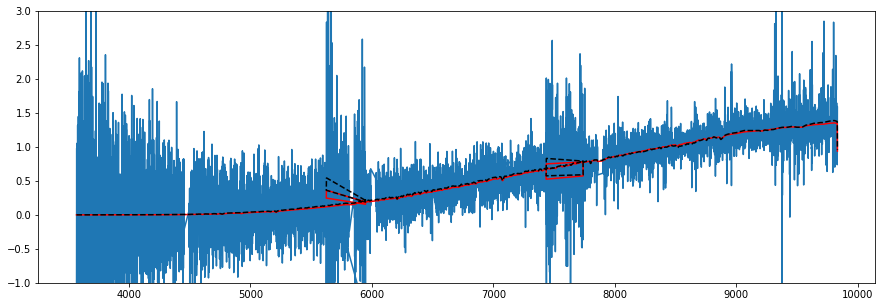

In [17]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave_obs[~mask], flux_obs[~mask])
sub.plot(wave_obs[~mask], flux_model_bestfit[~mask], c='r')
sub.plot(wave_obs[~mask], flux_model_true[~mask], c='k', ls='--')
sub.set_ylim(-1, 3)

In [18]:
flat_chain = desi_mcmc._flatten_chain(mcmc['mcmc_chain'])

Too few points to create valid contours


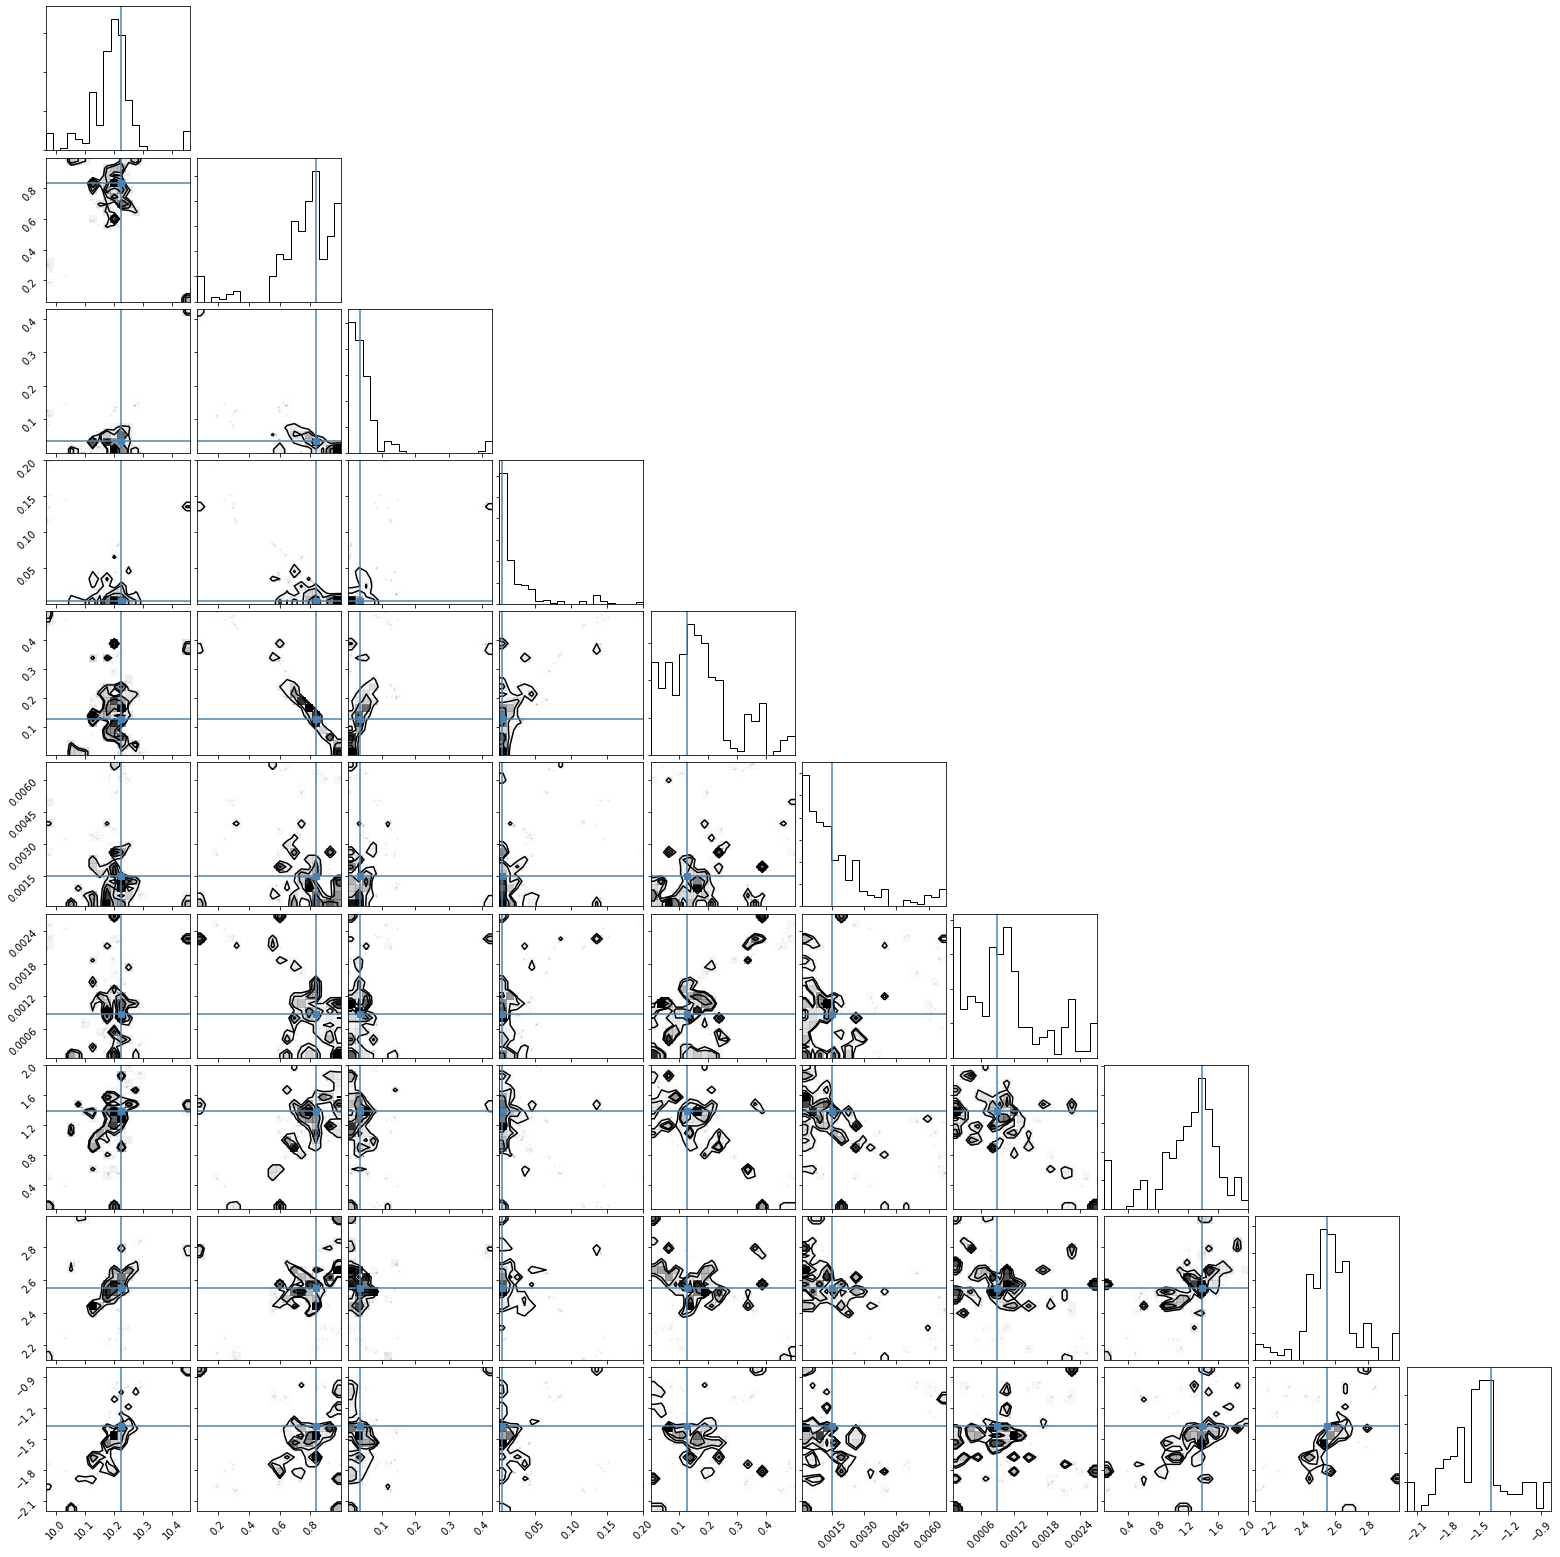

In [19]:
fig = DFM.corner(flat_chain, truths=theta_true)

In [20]:
sfr_100myr = desi_mcmc.model.avgSFR(flat_chain, meta['redshift'][igal], dt=0.1)
sfr_1gyr = desi_mcmc.model.avgSFR(flat_chain, meta['redshift'][igal], dt=1)
z_mw = desi_mcmc.model.Z_MW(flat_chain, meta['redshift'][igal])

In [21]:
props = np.array([flat_chain[:,0], sfr_100myr, sfr_1gyr, z_mw]).T
props_true = np.array([meta['logM_fiber'][igal], meta['sfr_100myr'][igal], meta['sfr_1gyr'][igal], meta['Z_MW'][igal]])
print(props_true)

[10.222261810366255 array([0.90455779]) array([1.39854298])
 array([0.00493123])]


/global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


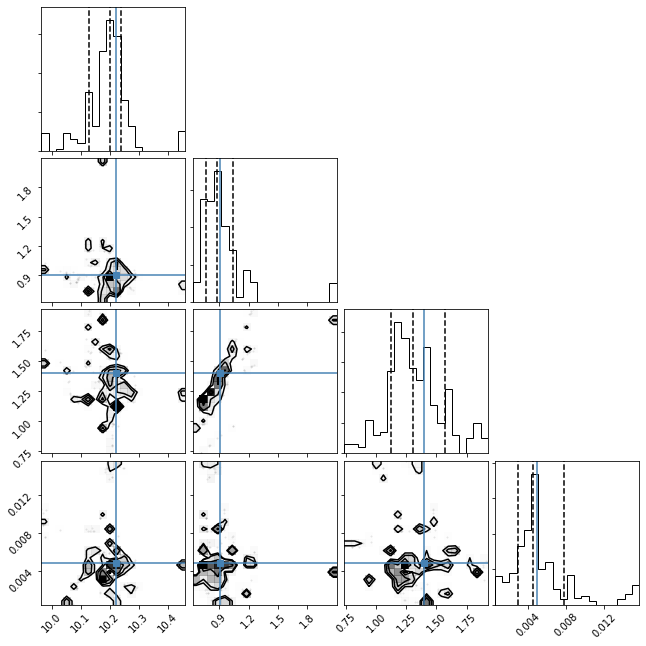

In [22]:
fig = DFM.corner(props, truths=props_true, quantiles=[0.16, 0.5, 0.84])

In [ ]:
_wave_nonoise = specs_nonoise['wave'].flatten()
wave_nonoise = _wave_nonoise[(_wave_nonoise > 3e3) & (_wave_nonoise < 1e4)]
flux_nonoise = specs_nonoise['flux'][igal][(_wave_nonoise > 3e3) & (_wave_nonoise < 1e4)]

In [ ]:
desi_mcmc2 = Infer.desiMCMC(
        prior=priors, 
        flux_calib=FluxCalib.no_flux_factor # no flux calibration necessary
        )

In [25]:
mcmc = desi_mcmc2.run(
        wave_obs=wave_nonoise, 
        flux_obs=flux_nonoise, 
        flux_ivar_obs=np.ones(len(flux_nonoise)), 
        zred=meta['redshift'][igal], 
        vdisp=150., # km/s velocity dispersion 
        mask='emline', 
        sampler='zeus',
        nwalkers=30, 
        burnin=10,
        opt_maxiter=10000,
        niter=100, 
        theta_start=priors.untransform(theta_true), 
        debug=True)

Initialising ensemble of 30 walkers...


--- initializing the walkers ---
initial theta = [10.222261810366255, 0.16497449661851094, 0.7881626973019368, 0.9702795094220389, 0.0014930174132865548, 0.0008842872835567901, 1.3913663620093129, 2.5496463994867313, -1.3782839070889756]
log Posterior(theta0) = -0.100761
--- burn-in ---


Sampling progress : 100%|██████████| 10/10 [00:14<00:00,  1.42s/it]
Initialising ensemble of 30 walkers...


--- running main MCMC ---


Sampling progress : 100%|██████████| 100/100 [01:47<00:00,  1.07s/it]

bestfit theta = [10.263291926198981, 0.6756321150786937, 0.11096239204740929, 0.031977287794807706, 0.18142820507908936, 0.004083013567628796, 0.00011911259179822836, 1.786451022790055, 2.4937563084052496, -1.391474502589046]
log Posterior = -0.132603
Speculator.sed: redshift = 0.200691
Speculator.sed: tage = 11.279885
Speculator.sed: theta [ 1.02632919e+01  6.75632115e-01  1.10962392e-01  3.19772878e-02
  1.81428205e-01  4.08301357e-03  1.19112592e-04  1.78645102e+00
  2.49375631e+00 -1.39147450e+00  1.12798853e+01]


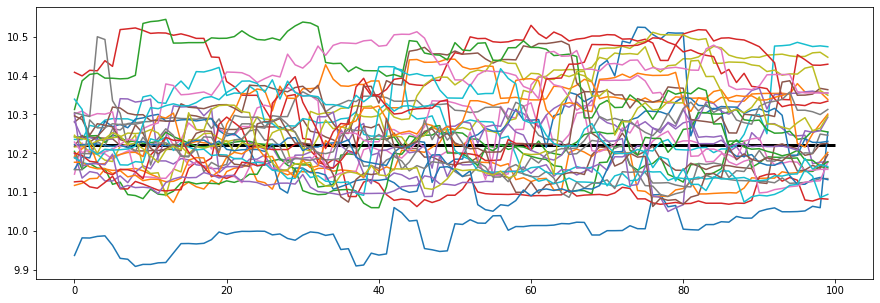

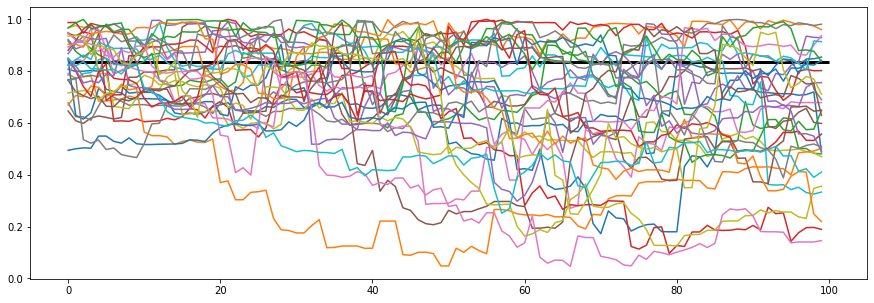

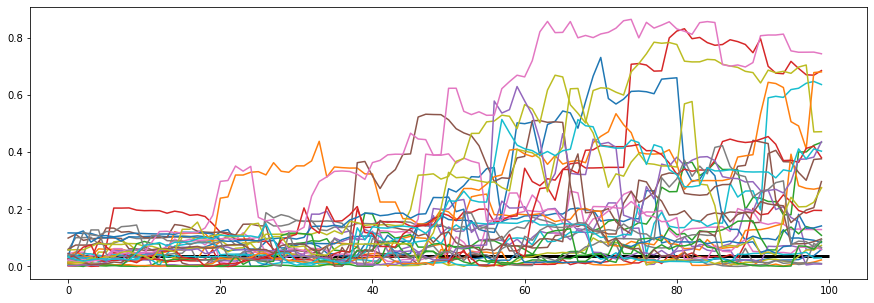

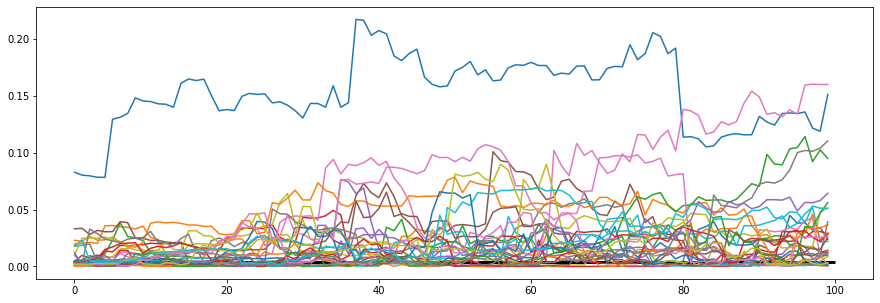

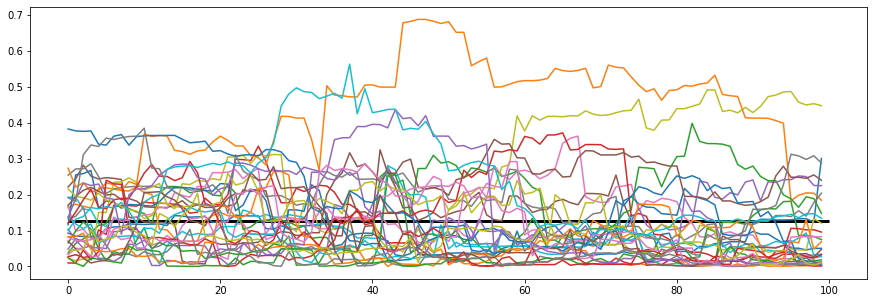

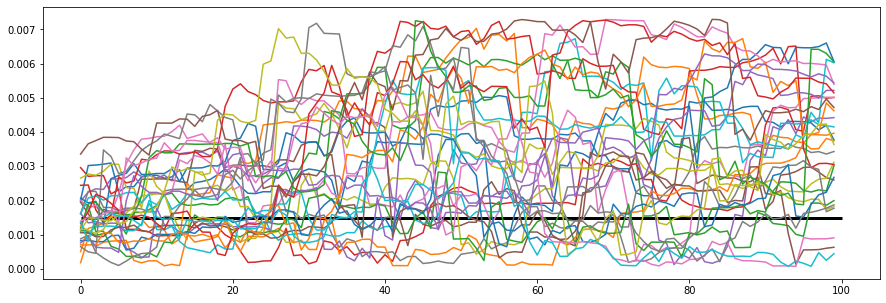

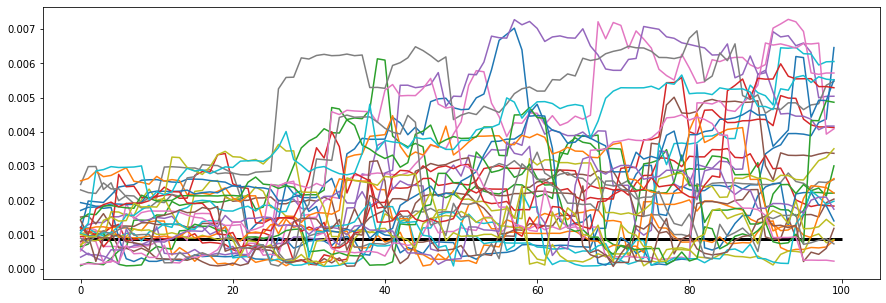

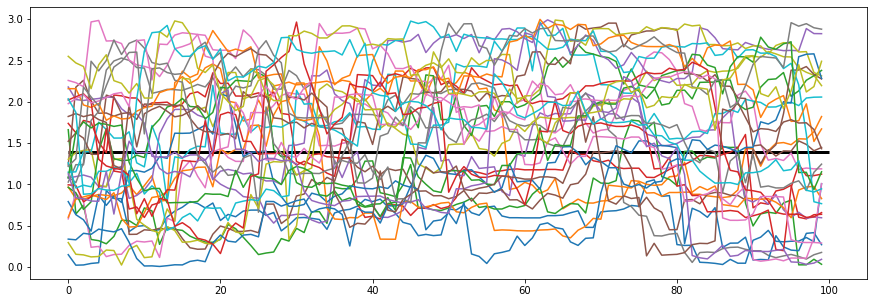

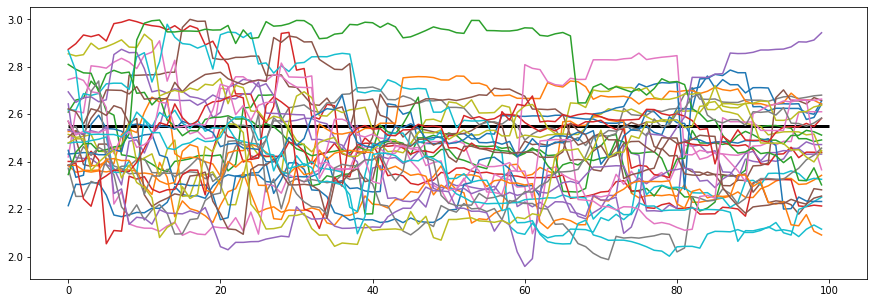

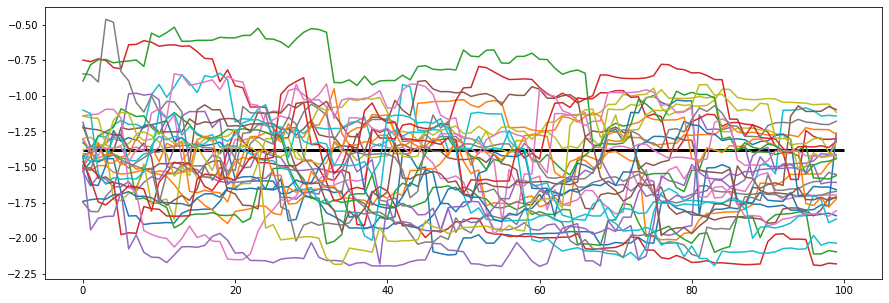

In [27]:
for i in range(mcmc['mcmc_chain'].shape[-1]):
    plt.figure(figsize=(15,5))
    plt.plot(mcmc['mcmc_chain'][:,:,i])
    plt.hlines(theta_true[i], 0, 100, color='k', linewidth=3)

(0, 2)

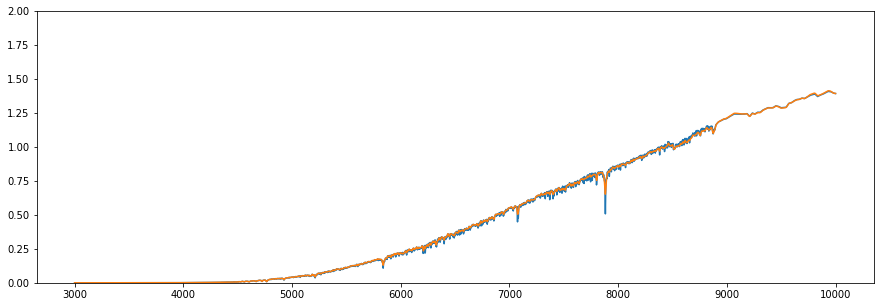

In [28]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave_nonoise, flux_nonoise)
sub.plot(wave_nonoise, mcmc['flux_spec_model'])
sub.set_ylim(0, 2)

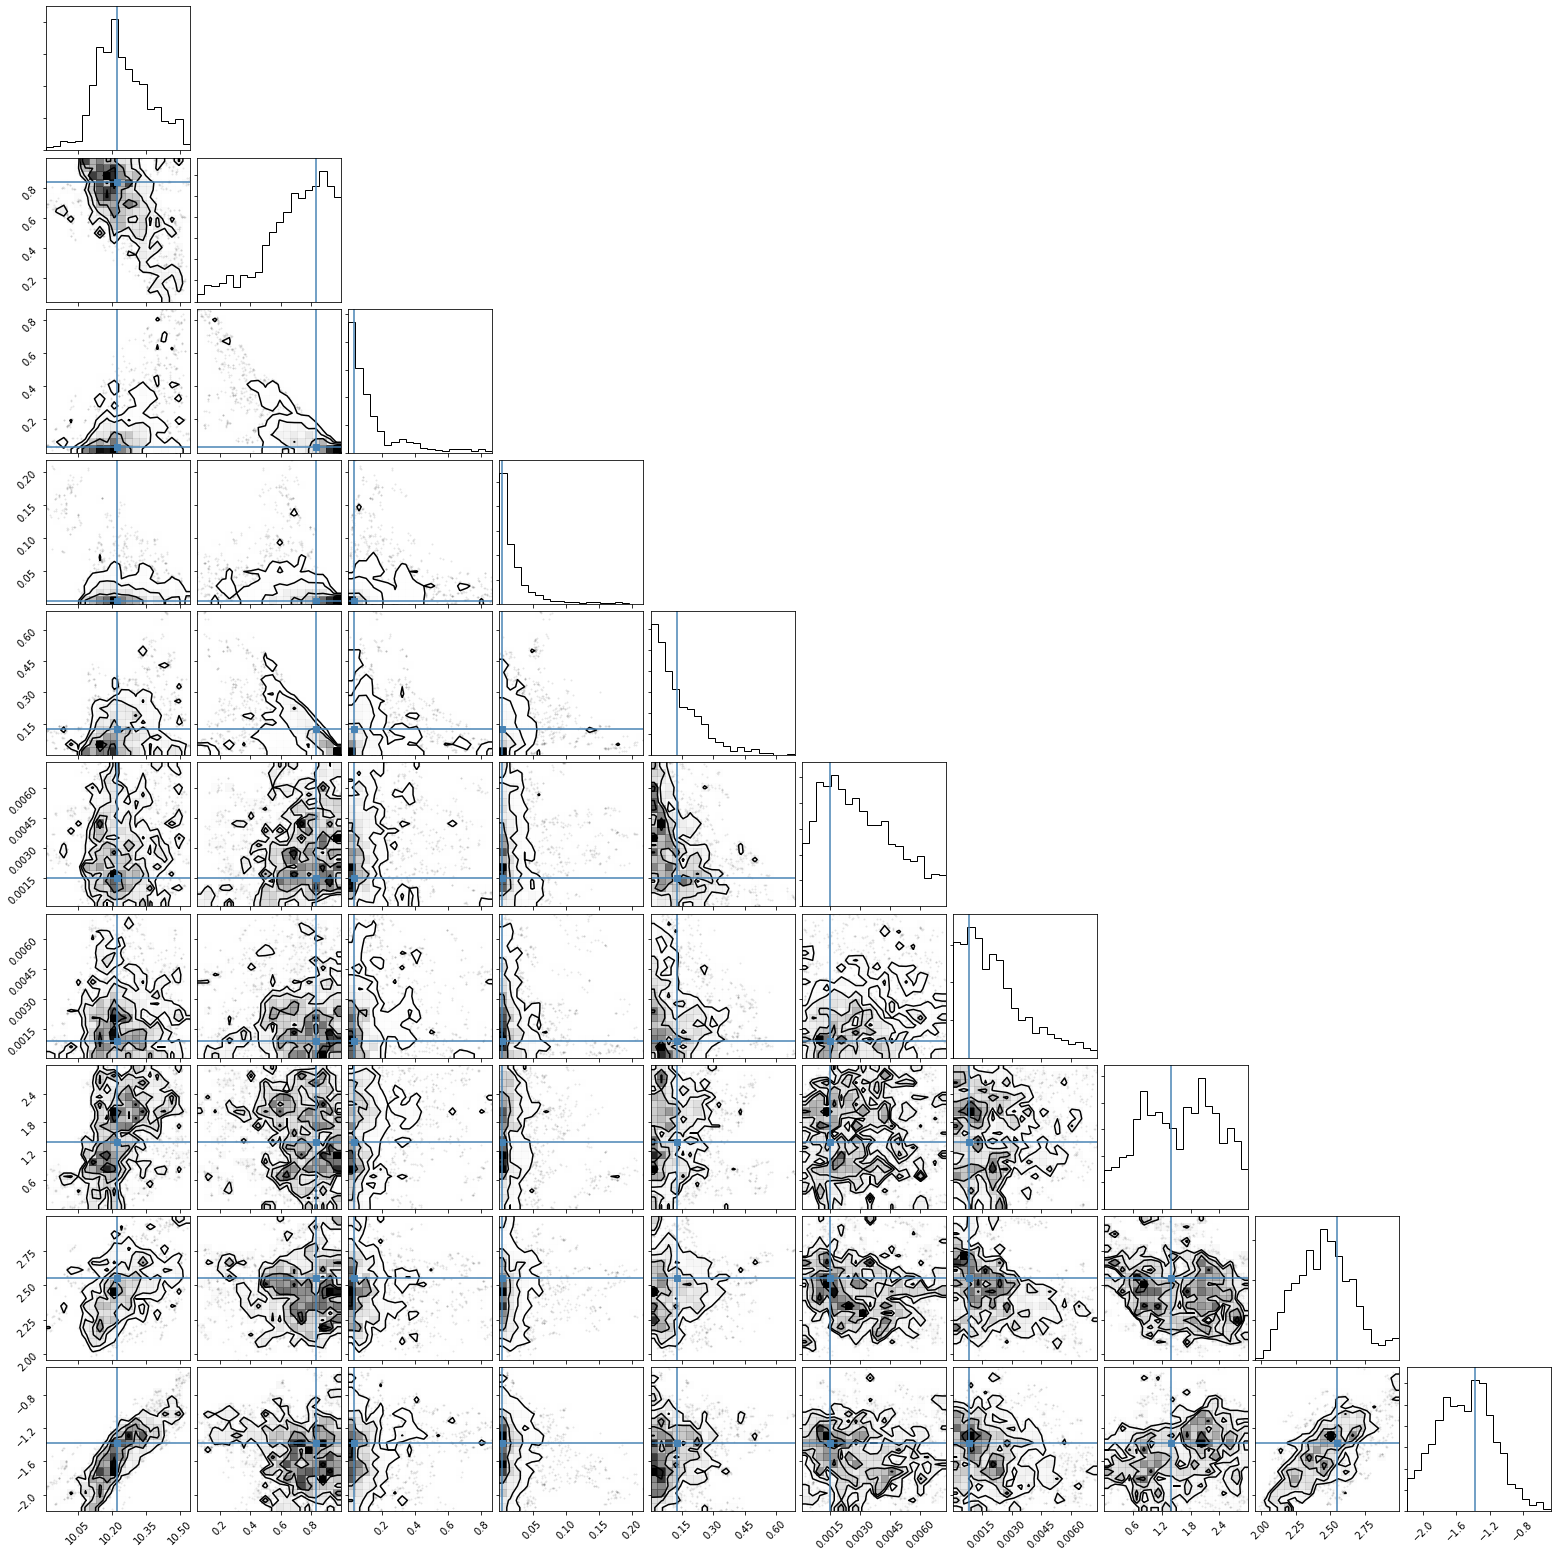

In [29]:
flat_chain = desi_mcmc2._flatten_chain(mcmc['mcmc_chain'][-500:,...])
fig = DFM.corner(flat_chain, truths=theta_true)

In [ ]:
lnpost_args, lnpost_kwargs = desi_mcmc2._lnPost_args_kwargs(
    wave_obs=wave_nonoise, 
    flux_obs=flux_nonoise, 
    flux_ivar_obs=np.ones(len(flux_nonoise)), 
    zred=meta['redshift'][igal], 
    vdisp=150., 
    mask='emline')

In [ ]:
print('logPost(theta bestfit) = %f' % desi_mcmc2.lnPost(priors.untransform(mcmc['theta_bestfit']), *lnpost_args, debug=True, **lnpost_kwargs))

In [ ]:
_, flux_bestfit = desi_mcmc2.model.sed(mcmc['theta_bestfit'], meta['redshift'][igal], wavelength=wave_nonoise)
_, flux_true = desi_mcmc2.model.sed(theta_true, meta['redshift'][igal], wavelength=wave_nonoise)

In [61]:
mask = lnpost_kwargs['mask']
print(np.sum((flux_nonoise[~mask] - flux_true[~mask])**2*np.ones(np.sum(~mask))))

2.968572344093373e-28


In [62]:
print(np.sum((flux_nonoise[~mask] - flux_bestfit[~mask])**2*np.ones(np.sum(~mask))))

0.07761955651970202


In [63]:
print('logPost(theta true) = %f' % desi_mcmc2.lnPost(priors.untransform(theta_true), *lnpost_args, debug=True, **lnpost_kwargs))

  log Prior = 0.000000
Speculator.sed: redshift = 0.200691
Speculator.sed: tage = 11.279885
Speculator.sed: theta [ 1.02222618e+01  8.35025503e-01  3.49477524e-02  3.86445863e-03
  1.26162286e-01  1.49301741e-03  8.84287284e-04  1.39136636e+00
  2.54964640e+00 -1.37828391e+00  1.12798853e+01]
desiMCMC.lnLike: Spectroscopic Chi2 = 0.201522
desiMCMC.lnLike: total Chi2 = 0.201522
logPost(theta true) = -0.100761


In [ ]:
sfr_100myr = desi_mcmc.model.avgSFR(flat_chain, meta['redshift'][igal], dt=0.1)
sfr_1gyr = desi_mcmc.model.avgSFR(flat_chain, meta['redshift'][igal], dt=1)
z_mw = desi_mcmc.model.Z_MW(flat_chain, meta['redshift'][igal])
props = np.array([flat_chain[:,0], sfr_100myr, sfr_1gyr, z_mw]).T
print(props_true)

In [ ]:
fig = DFM.corner(props[-10000:,:], truths=props_true, quantiles=[0.16, 0.5, 0.84])